<a href="https://colab.research.google.com/github/scarlettyu2023/AI_agent_workshop/blob/main/Topic4Exploring/Topic_4_Exploring_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import userdata
import os
# Make it available like system env vars
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

Study the code of the toolnode_example.py and the react_agent_example.py. Run them and and look at the Mermaid graphs they produce.  Answer the following questions in your portfolio:

What features of Python does ToolNode use to dispatch tools in parallel?  What kinds of tools would most benefit from parallel dispatch?

How do the two programs handle special inputs such as "verbose" and "exit"?

Compare the graph diagrams of the two programs.  How do they differ if at all?

What is an example of a case where the structure imposed by the LangChain react agent is too restrictive and you'd want to pursue the toolnode approach?  

In [7]:
!python toolnode_example.py

LangGraph Manual Tool Calling - Persistent Multi-Turn Conversation

This system uses manual tool calling with ToolNode:
  - call_model: Invokes LLM with tool bindings
  - ToolNode: Executes requested tools in parallel
  - Loop: tools -> call_model (until no more tools needed)
  - Single persistent conversation across all turns
  - History managed automatically (trimmed after 100 messages)

Commands:
  - Type 'quit' or 'exit' to end the conversation
  - Type 'verbose' to enable detailed tracing
  - Type 'quiet' to disable detailed tracing

Available tools:
  - get_weather(location): Get weather information
  - get_population(city): Get population data
  - calculate(expression): Evaluate math expressions
[SYSTEM] Conversation graph created successfully (using manual ToolNode)
[SYSTEM] Graph visualization saved to 'langchain_manual_tool_graph.png'

[SYSTEM] Starting conversation...


NODE: input_node

You: verbose
[SYSTEM] Verbose mode enabled
[DEBUG] Routing back to input (verbose toggle

In [8]:
!python react_agent_example.py

LangGraph ReAct Agent - Persistent Multi-Turn Conversation

This system uses create_react_agent with graph-based looping:
  - Single persistent conversation across all turns
  - History managed automatically (trimmed after 100 messages)
  - Loops via graph edges (no Python loops or checkpointing)

Commands:
  - Type 'quit' or 'exit' to end the conversation
  - Type 'verbose' to enable detailed tracing
  - Type 'quiet' to disable detailed tracing

Available tools:
  - get_weather(location): Get weather information
  - get_population(city): Get population data
  - calculate(expression): Evaluate math expressions
/content/react_agent_example.py:375: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_agent = create_react_agent(
[SYSTEM] ReAct agent created successfully
[SYSTEM] ReAct agent graph saved to 'langchain_react_ag

#1. What features of Python does ToolNode use to dispatch tools in parallel?  What kinds of tools would most benefit from parallel dispatch?


**Python features ToolNode relies on**
- **`asyncio` concurrency (`async`/`await`)**: when the LLM returns multiple `tool_calls` in one step, ToolNode can schedule them concurrently (conceptually like `asyncio.gather(...)`).
- **Thread executors for blocking tools**: if a tool is a normal synchronous `def` that would block, it can be run in a **thread pool/executor** so multiple tool calls can overlap instead of blocking the event loop.

**Tools that benefit most from parallel dispatch**
- **Independent, I/O-bound tools** where latency dominates:
  - Remote API/microservice calls (tools on different servers), e.g., `get_weather("Boston")` + `get_population("Boston")`
  - Multi-retrieval/search fan-out (query multiple sources in parallel)
  - Database queries, network requests, and multi-file reads
- Less benefit for **CPU-bound pure Python** computation (often GIL-limited) or tool calls that must run **sequentially** due to dependencies.


#2. How do the two programs handle special inputs such as "verbose" and "exit"?

Both `toolnode_example.py` and `react_agent_example.py` handle special inputs **outside the LLM** in `input_node()` using the `command` field plus routing logic.

- **`verbose`**: sets `command="verbose"` and `verbose=True`, then routes **back to `input_node`** (no model/agent call).
  - Observed output: `Routing back to input (verbose toggle)`
- **`exit`**: sets `command="exit"` and routes to **`END`**, terminating the graph.
  - Observed output: `Routing to END (exit requested)`


#3. Compare the graph diagrams of the two programs.  How do they differ if at all?


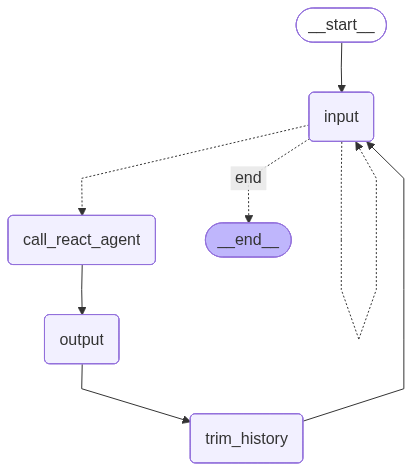

In [11]:
from IPython.display import Image
Image('/content/langchain_conversation_graph.png')

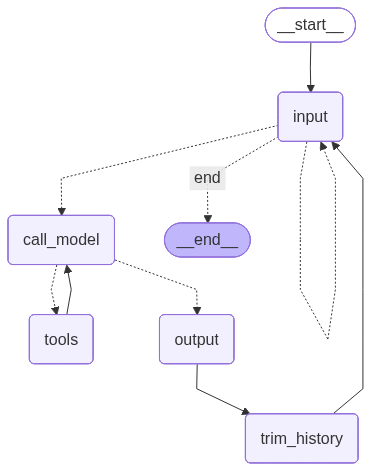

In [12]:
Image('/content/langchain_manual_tool_graph.png')

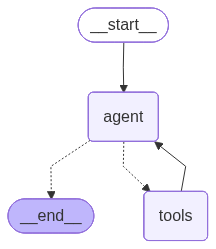

In [13]:
Image('/content/langchain_react_agent.png')

# Comparison of the two graph diagrams

## What’s the same
- Both follow the same outer “conversation turn” structure:

  __start__ → input → (agent reasoning / possible tool use) → output → trim_history → input → …

- Both can end early via a conditional branch to __end__.

## What differs

### 1) Where the tool loop lives (shown vs hidden)
- **Conversation graph**
  - Has a single middle node: `call_react_agent`
  - Flow: `input → call_react_agent → output`
  - The ReAct loop (`LLM → tools → LLM → ...`) is **inside** `call_react_agent`, so it is **not visible** in the diagram.

- **Manual-tool graph**
  - Splits the middle into `call_model` and `tools`
  - Flow: `input → call_model ↔ tools → output`
  - The loop is **explicit**: `call_model` calls the LLM, routes to `tools` if tool_calls exist, then returns to `call_model`.

### 2) Granularity / abstraction
- Conversation graph: **higher-level**, treats the agent as a black box.
- Manual-tool graph: **lower-level**, exposes the agent’s internal control flow.

### 3) Node naming
- Conversation graph uses `call_react_agent` (wrapped agent).
- Manual-tool graph uses `call_model` + `tools` (manual agent loop).

## Bottom line
- The diagrams differ in **how much detail they expose**, not in the overall intent:
  - Both implement an agent that can use tools,
  - but only the manual-tool graph shows the tool-use loop explicitly.


#4. What is an example of a case where the structure imposed by the LangChain react agent is too restrictive and you'd want to pursue the toolnode approach?  

A good way to think about it:

- **LangChain ReAct agent** gives you a *fixed control loop*:  
  `LLM → (maybe tool calls) → tool results → LLM → … → final answer`
- **ToolNode / LangGraph approach** lets you design *arbitrary control flow*: branching, parallelism, gating, retries, human-in-the-loop, multi-stage pipelines, etc.

Below are concrete cases where ReAct’s structure becomes too restrictive.

---

## Example 1: Multi-stage pipeline with hard gates (plan → retrieve → verify → write)
**Scenario:** You want a “research assistant” that must obey:
1. Make a plan (no tools allowed yet)
2. Retrieve sources (tools allowed)
3. Verify claims against sources (tools + checks)
4. Only then write the final answer (no more tools)

**Why ReAct is restrictive:**  
ReAct doesn’t naturally enforce *phase separation*. The LLM can:
- call tools prematurely,
- skip verification,
- keep calling tools during the writing phase,
unless you rely on prompt discipline (which is brittle).

**Why ToolNode helps:**  
You build explicit nodes:
- `plan_node` (tools disabled)
- `retrieve_node` (tools enabled)
- `verify_node` (tools enabled + validation logic)
- `write_node` (tools disabled)
and hard-wire the transitions so the model *cannot* violate the workflow.

---

## Example 2: Deterministic validation + retry loops (schema, safety, or correctness)
**Scenario:** You’re extracting structured JSON (or an action command) that must validate:
- strict JSON schema
- allowed values
- safety constraints
- business rules (e.g., “amount <= account_balance”)

If validation fails, you want:
- automatic retries with error feedback,
- escalating to a fallback model,
- or a human review node.

**Why ReAct is restrictive:**  
ReAct’s loop is essentially “LLM decides next tool call” and doesn’t give you
a clean, first-class place to enforce *deterministic validators + controlled retry policy*.

**Why ToolNode helps:**  
You can insert nodes like:
- `validate_output`
- `repair_json`
- `retry_with_feedback`
- `fallback_model`
and route based on deterministic checks, not the LLM’s self-assessment.

---

## Example 3: Parallel tool execution and join (fan-out / fan-in)
**Scenario:** You want to call multiple tools concurrently:
- query 3 different retrievers
- fetch from 2 APIs
- run a local compute tool
Then merge results and have the model synthesize.

**Why ReAct is restrictive:**  
Classic ReAct is sequential: one reasoning step → tool call(s) → back.
You *can* cram multiple tool calls into one step, but:
- the agent may not reliably issue all calls,
- you don’t get clean orchestration semantics,
- joining/merging logic becomes messy.

**Why ToolNode helps:**  
LangGraph lets you do explicit fan-out/fan-in:
- `dispatch_queries` → `retriever_A`, `retriever_B`, `retriever_C` (parallel)
- `join_results` (deterministic merge)
- `synthesize`

---

## Example 4: Human-in-the-loop approval checkpoints
**Scenario:** Before sending an email, filing a ticket, spending money, or taking an external action,
you must pause for human approval.

**Why ReAct is restrictive:**  
ReAct will happily continue unless you heavily prompt it not to.
You want the graph to literally *stop* and wait for approval.

**Why ToolNode helps:**  
Add an `approval_node` that halts execution unless an `approved=True` signal is provided.

---

## The “one-sentence” answer
Use ToolNode when you need **control-flow guarantees** (phases, gating, validation, retries, parallelism, or approvals) that you *cannot trust prompting alone* to enforce inside a ReAct loop.
